# Scrape data

* My functions which i used to scrape the data

In [3]:
gold_historical = "https://services.bullionstar.com/spot-chart/getChart?product=false&productId=0&productTo=false&productIdTo=0&fromIndex=XAU&toIndex=USD&period=MAX&width=600&height=300&timeZoneId=Africa%2FCairo&weightUnit=g"
silver_historical = "https://services.bullionstar.com/spot-chart/getChart?product=false&productId=0&productTo=false&productIdTo=0&fromIndex=XAG&toIndex=USD&period=MAX&width=600&height=300&timeZoneId=Africa%2FCairo&weightUnit=g"

usd_to_egp_url = "https://webql-redesign.cnbcfm.com/graphql?operationName=getQuoteChartData&variables=%7B%22symbol%22%3A%22EGP%3D%22%2C%22timeRange%22%3A%22ALL%22%7D&extensions=%7B%22persistedQuery%22%3A%7B%22version%22%3A1%2C%22sha256Hash%22%3A%2261b6376df0a948ce77f977c69531a4a8ed6788c5ebcdd5edd29dd878ce879c8d%22%7D%7D"

In [4]:
import requests
from datetime import datetime
import pandas as pd

In [5]:
def fetch_data(url: str) -> dict | None:
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        st.error(f"Failed to fetch data. Status code: {response.status_code}")
        return None

In [6]:
def process_usd_egp_data(data: dict) -> pd.DataFrame:
    bars = data["data"]["chartData"]["priceBars"]
    dates = []
    prices = []

    for bar in bars:
        trade_time = bar.get("tradeTimeinMills")
        close_price = bar.get("close")

        if trade_time is not None and close_price != "-9999401.0000":
            try:
                dates.append(int(trade_time))
                prices.append(float(close_price))
            except (ValueError, TypeError):
                st.warning(
                    f"Invalid data encountered for trade time: {trade_time} or close price: {close_price}"
                )

    if not dates or not prices:
        st.error("No valid data available for the selected time range.")
        return pd.DataFrame()

    df = pd.DataFrame({"date": dates, "price": prices})
    df["date"] = pd.to_datetime(df["date"], unit="ms")
    return df

In [7]:
def process_metal_data(data: dict) -> pd.DataFrame:
    dates = []
    prices = []

    for entry in data["dataSeries"]:
        startDate = 946940400000
        startDate_seconds = startDate / 1000
        date = int(str(entry["d"]) + "00")
        timestamp = startDate_seconds + date
        date = datetime.utcfromtimestamp(timestamp)
        dates.append(date)

        price = entry["v"]
        prices.append(price)

    df = pd.DataFrame({"date": dates, "price": prices})
    return df

In [8]:
def load_and_prepare(ticker: str) -> pd.DataFrame:
    data = yfinance.download(ticker)
    data["date"] = data.index
    data.reset_index(drop=True, inplace=True)
    data.drop("Volume", inplace=True, axis=1)
    return data

# Import & Show

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance

In [10]:
def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df['SMA_30'] = df['Close'].rolling(window=30).mean()
    df['SMA_90'] = df['Close'].rolling(window=90).mean()
    
    df['price_change'] = df['Close'].pct_change() * 100
    
    df.rename(columns={"Close": "price"}, inplace=True)
    
    dropped_column = ["Open", "High", "Low", "Adj Close"]
    df.drop(dropped_column, axis=1, inplace=True)
    
    return df

In [11]:
gold = pd.read_csv("Gold_USD.csv")
silver = pd.read_csv("Silver_USD.csv")
doller = load_and_prepare("EGP=X")

[*********************100%***********************]  1 of 1 completed


In [12]:
doller = add_technical_indicators(doller)

In [13]:
gold

,date,price,SMA_30,SMA_90,price_change
0,2000-01-03 23:00:00,1.1401,NaN,NaN,NaN
1,2000-01-08 22:00:00,1.1360,NaN,NaN,-0.003596
2,2000-01-15 22:00:00,1.1321,NaN,NaN,-0.003433
3,2000-01-22 22:00:00,1.1250,NaN,NaN,-0.006272
4,2000-01-29 22:00:00,1.1294,NaN,NaN,0.003911
...,...,...,...,...,...
1286,2024-09-14 21:00:00,12.5872,12.316770,11.873493,0.011890
1287,2024-09-21 21:00:00,12.5438,12.325450,11.893946,-0.003448
1288,2024-09-28 22:00:00,12.7126,12.344527,11.916273,0.013457
1289,2024-10-05 22:00:00,12.6499,12.363603,11.939047,-0.004932


# Univariate Analysis (Single Variable at a Time)

In [15]:
def univariate_analysis(df: pd.DataFrame, category: str):
    plt.figure(figsize=(16, 24))
    plt.subplot(4, 2, 1)
    sns.histplot(df['price'], kde=True, color='blue')
    plt.title(f'Price Distribution for {category}')

    plt.subplot(4, 2, 2)
    sns.boxplot(x=df['price'], color='lightblue')
    plt.title(f'Price Boxplot for {category}')

    plt.subplot(4, 2, 3)
    plt.plot(pd.to_datetime(df['date']), df['SMA_30'], label='SMA 30', color='orange')
    plt.plot(pd.to_datetime(df['date']), df['SMA_90'], label='SMA 90', color='green')
    plt.title(f'SMA 30 and SMA 90 over Time for {category}')
    plt.legend()

    plt.subplot(4, 2, 4)
    sns.histplot(df['SMA_30'], kde=True, color='orange', label='SMA 30')
    sns.histplot(df['SMA_90'], kde=True, color='green', label='SMA 90')
    plt.title(f'SMA 30 & SMA 90 Distribution for {category}')

    plt.subplot(4, 2, 4)
    sns.histplot(df['SMA_30'], kde=True, color='orange', label='SMA 30')
    sns.histplot(df['SMA_90'], kde=True, color='green', label='SMA 90')
    plt.title(f'SMA 30 & SMA 90 Distribution for {category}')

    plt.subplot(4, 2, 5)
    sns.histplot(df['price_change'], kde=True, color='red')
    plt.title(f'Price Change Distribution')

    df['price_change_category'] = pd.cut(df['price_change'], bins=[-np.inf, 0, np.inf], labels=['Negative', 'Positive'])

    plt.subplot(4, 2, 6)
    sns.countplot(x='price_change_category', data=df, palette='Set1')
    plt.title(f'Price Change Category (Positive/Negative) for {category}')


    plt.subplot(4, 2, 7)
    plt.plot(pd.to_datetime(df['date']), df['price'], label='Price', color='blue')
    plt.plot(pd.to_datetime(df['date']), df['SMA_30'], label='SMA 30', color='orange')
    plt.plot(pd.to_datetime(df['date']), df['SMA_90'], label='SMA 90', color='green')
    plt.title(f'Price vs SMA 30 and SMA 90 for {category}')
    plt.legend()

    plt.subplot(4, 2, 8)
    plt.plot(pd.to_datetime(df['date']), df['price'] - df['SMA_30'], label='Price - SMA 30', color='orange')
    plt.plot(pd.to_datetime(df['date']), df['price'] - df['SMA_90'], label='Price - SMA 90', color='green')
    plt.title(f'Price-SMA Spread Over Time for {category}')
    plt.legend()

    plt.tight_layout()
    plt.show()


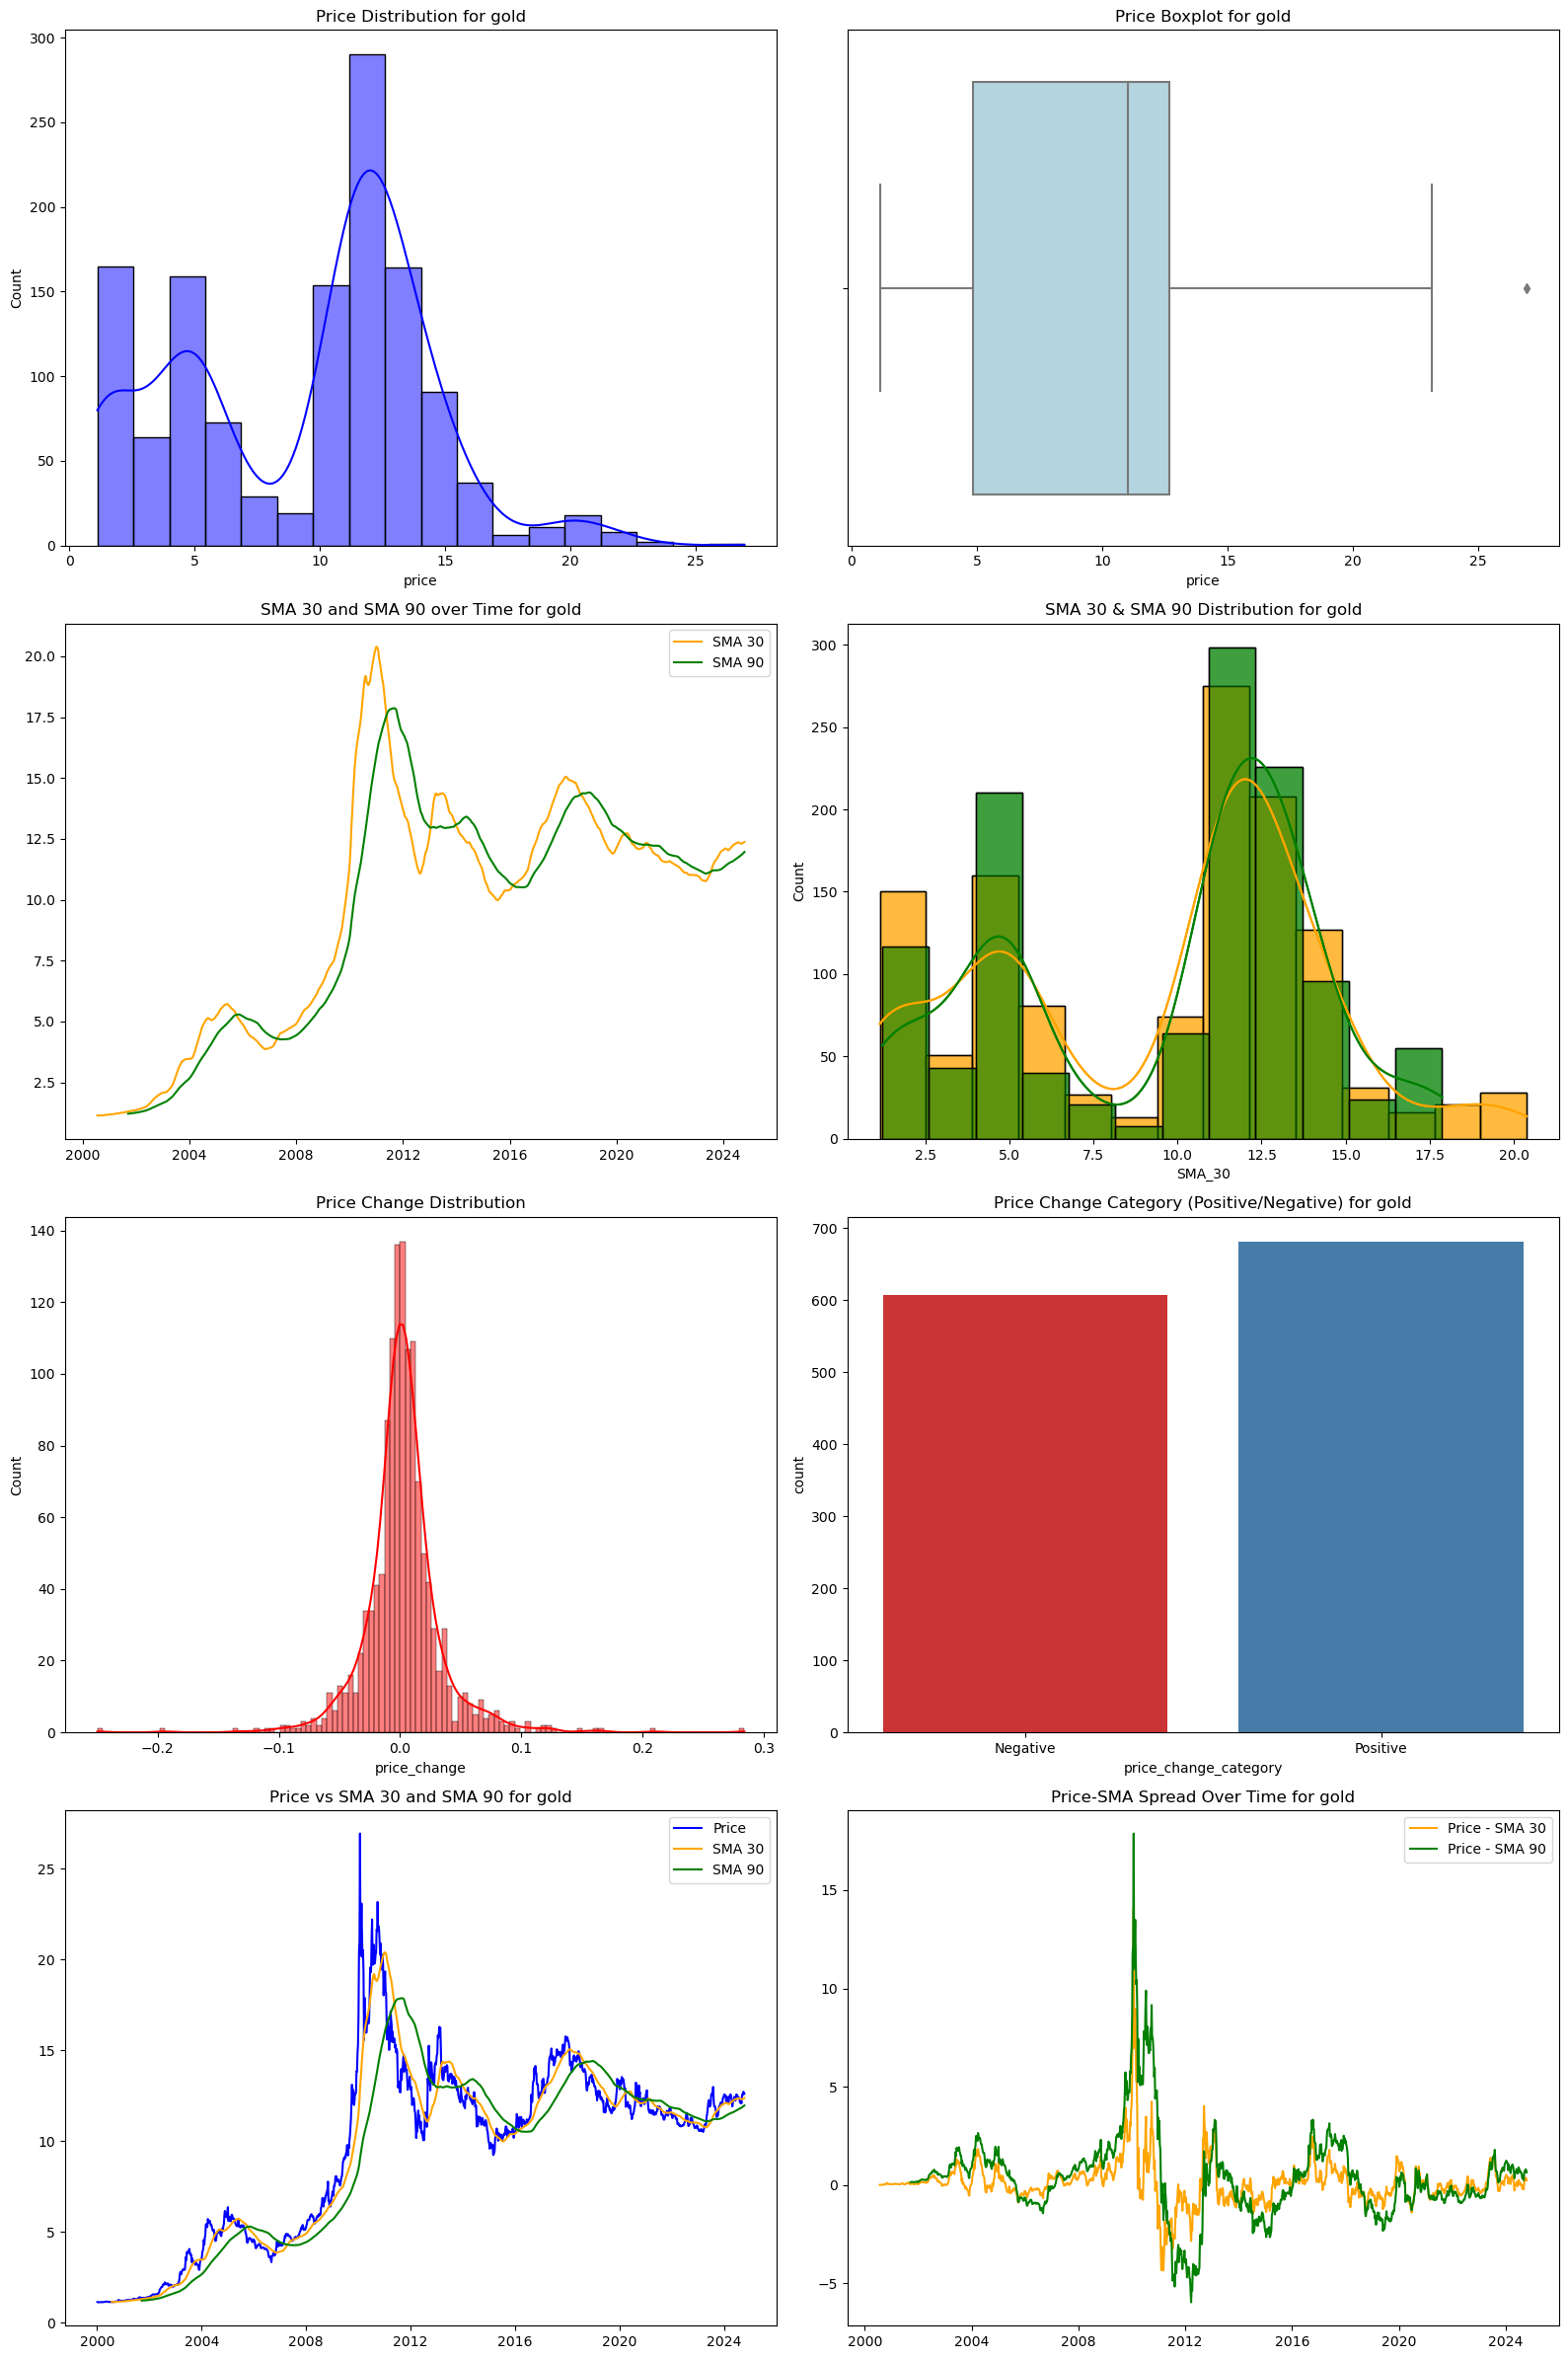

In [16]:
univariate_analysis(gold, "gold")

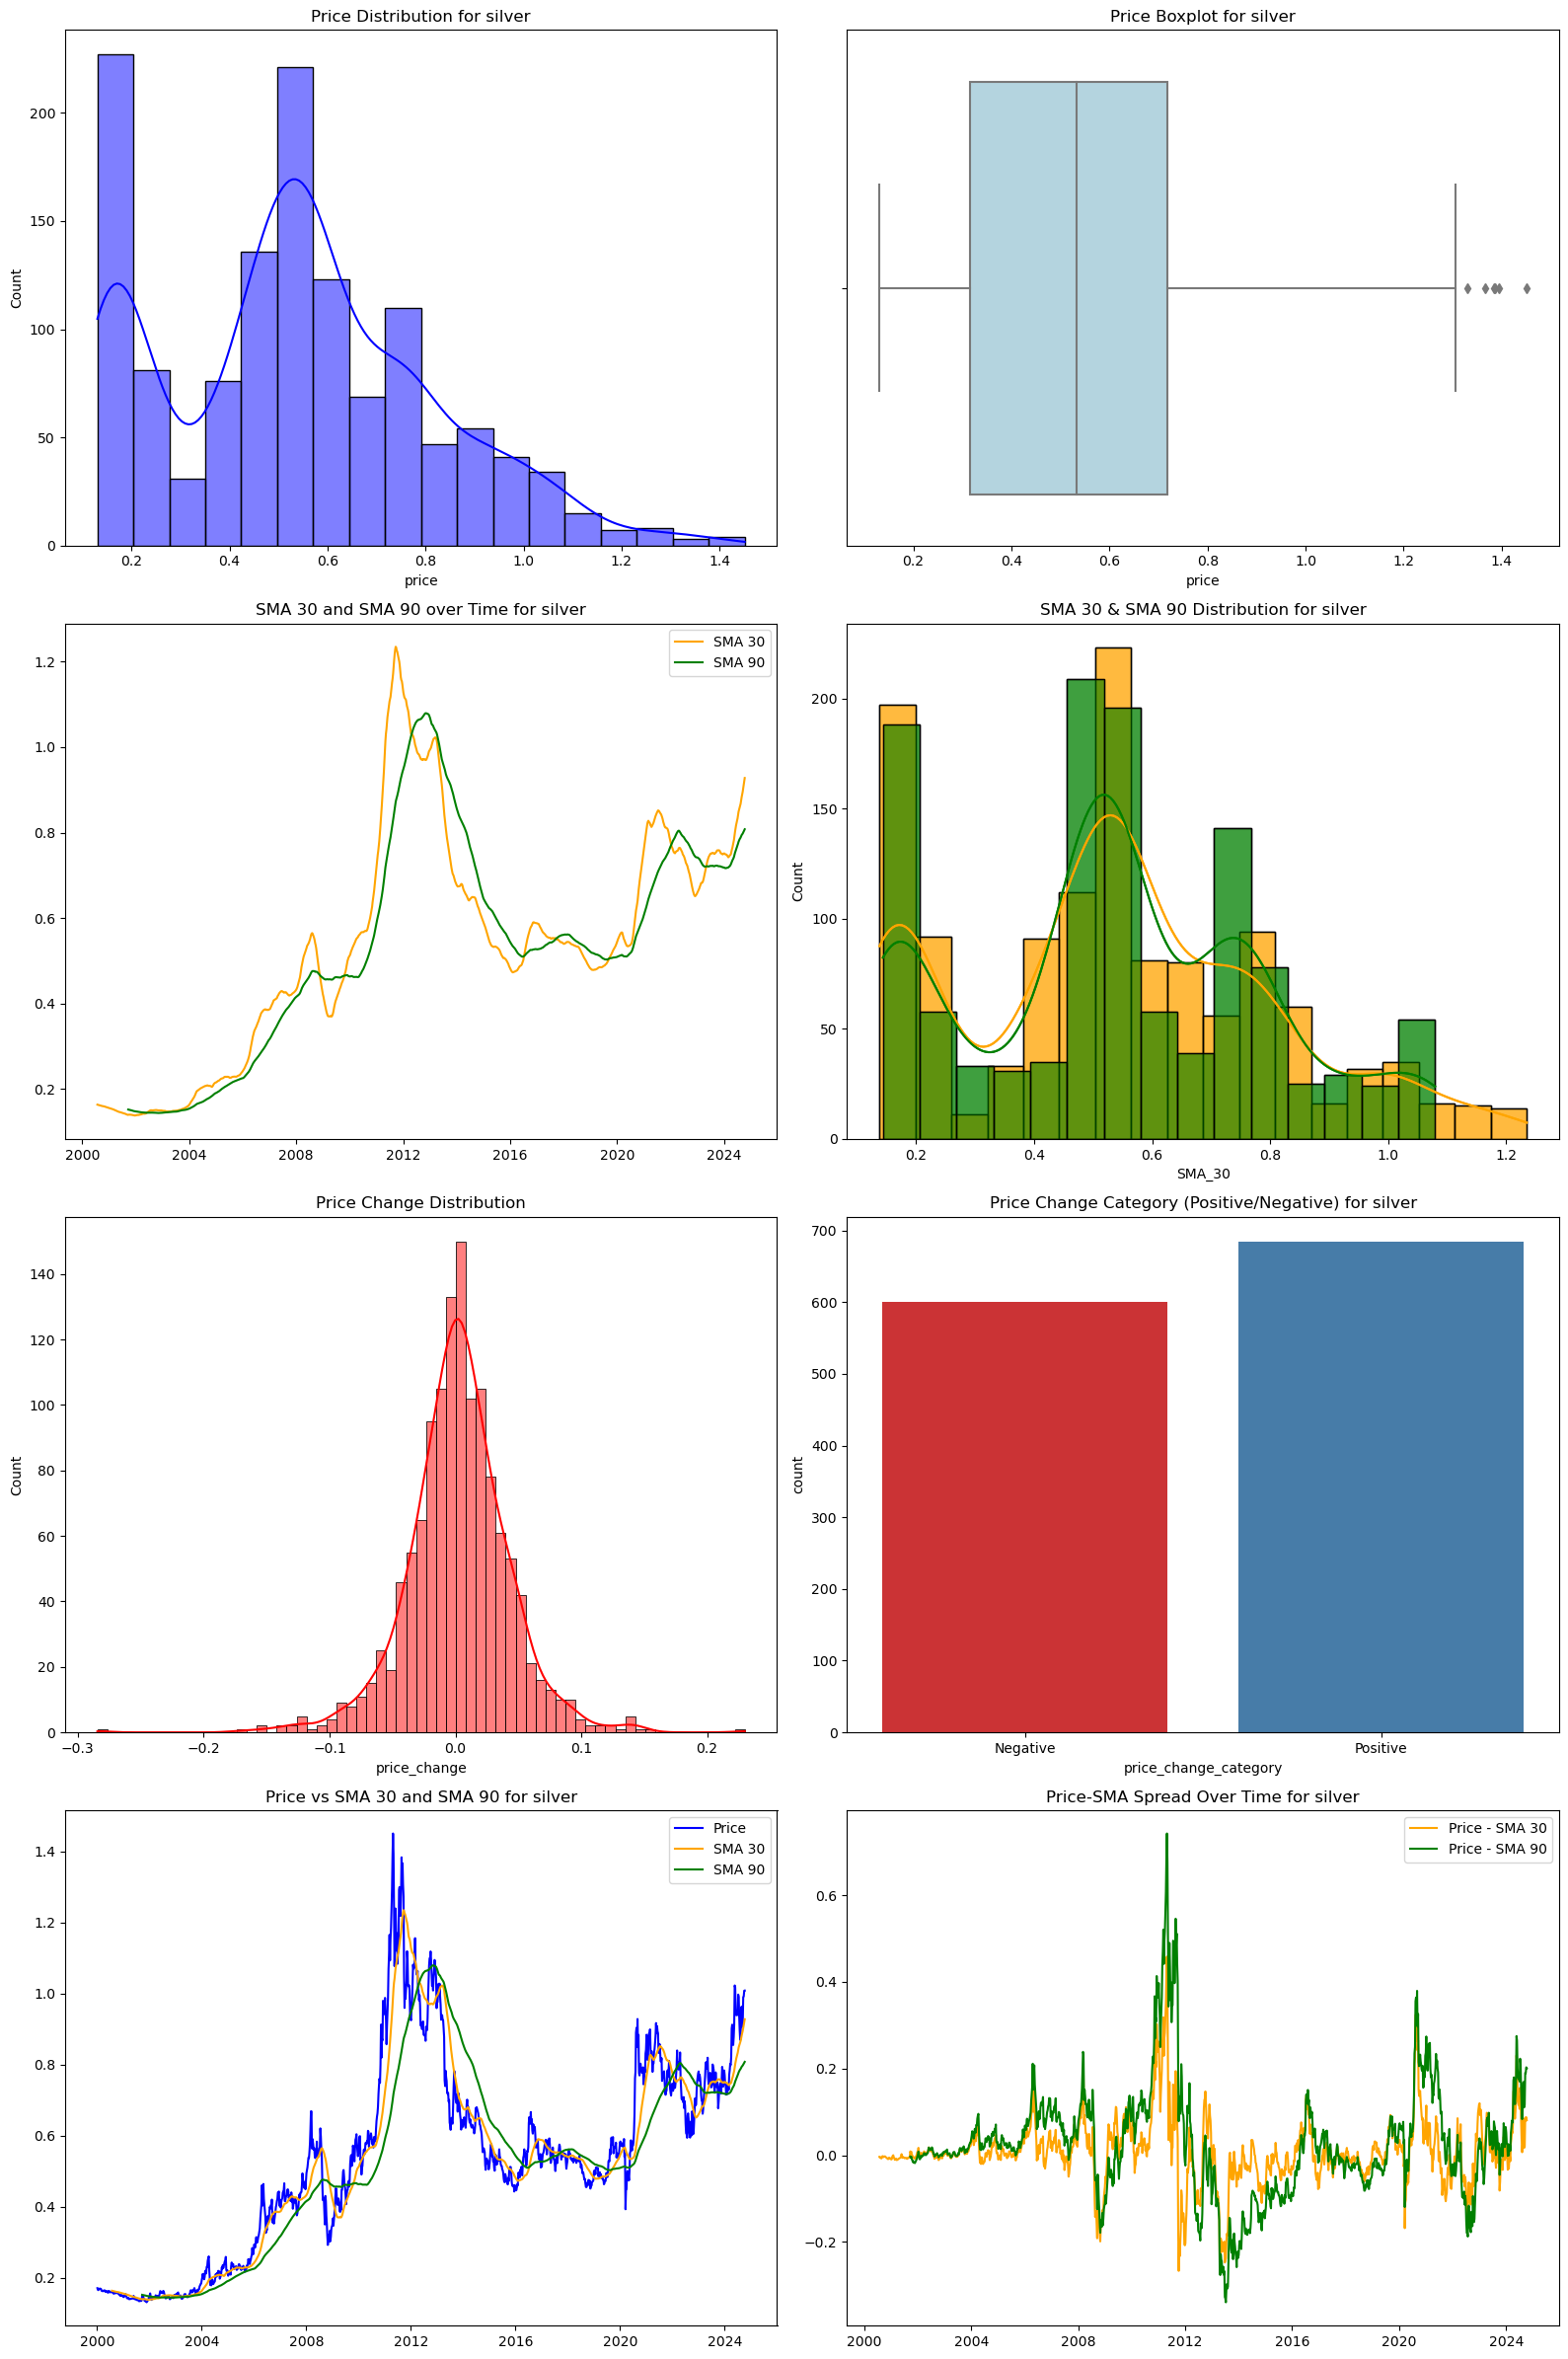

In [17]:
univariate_analysis(silver, "silver")

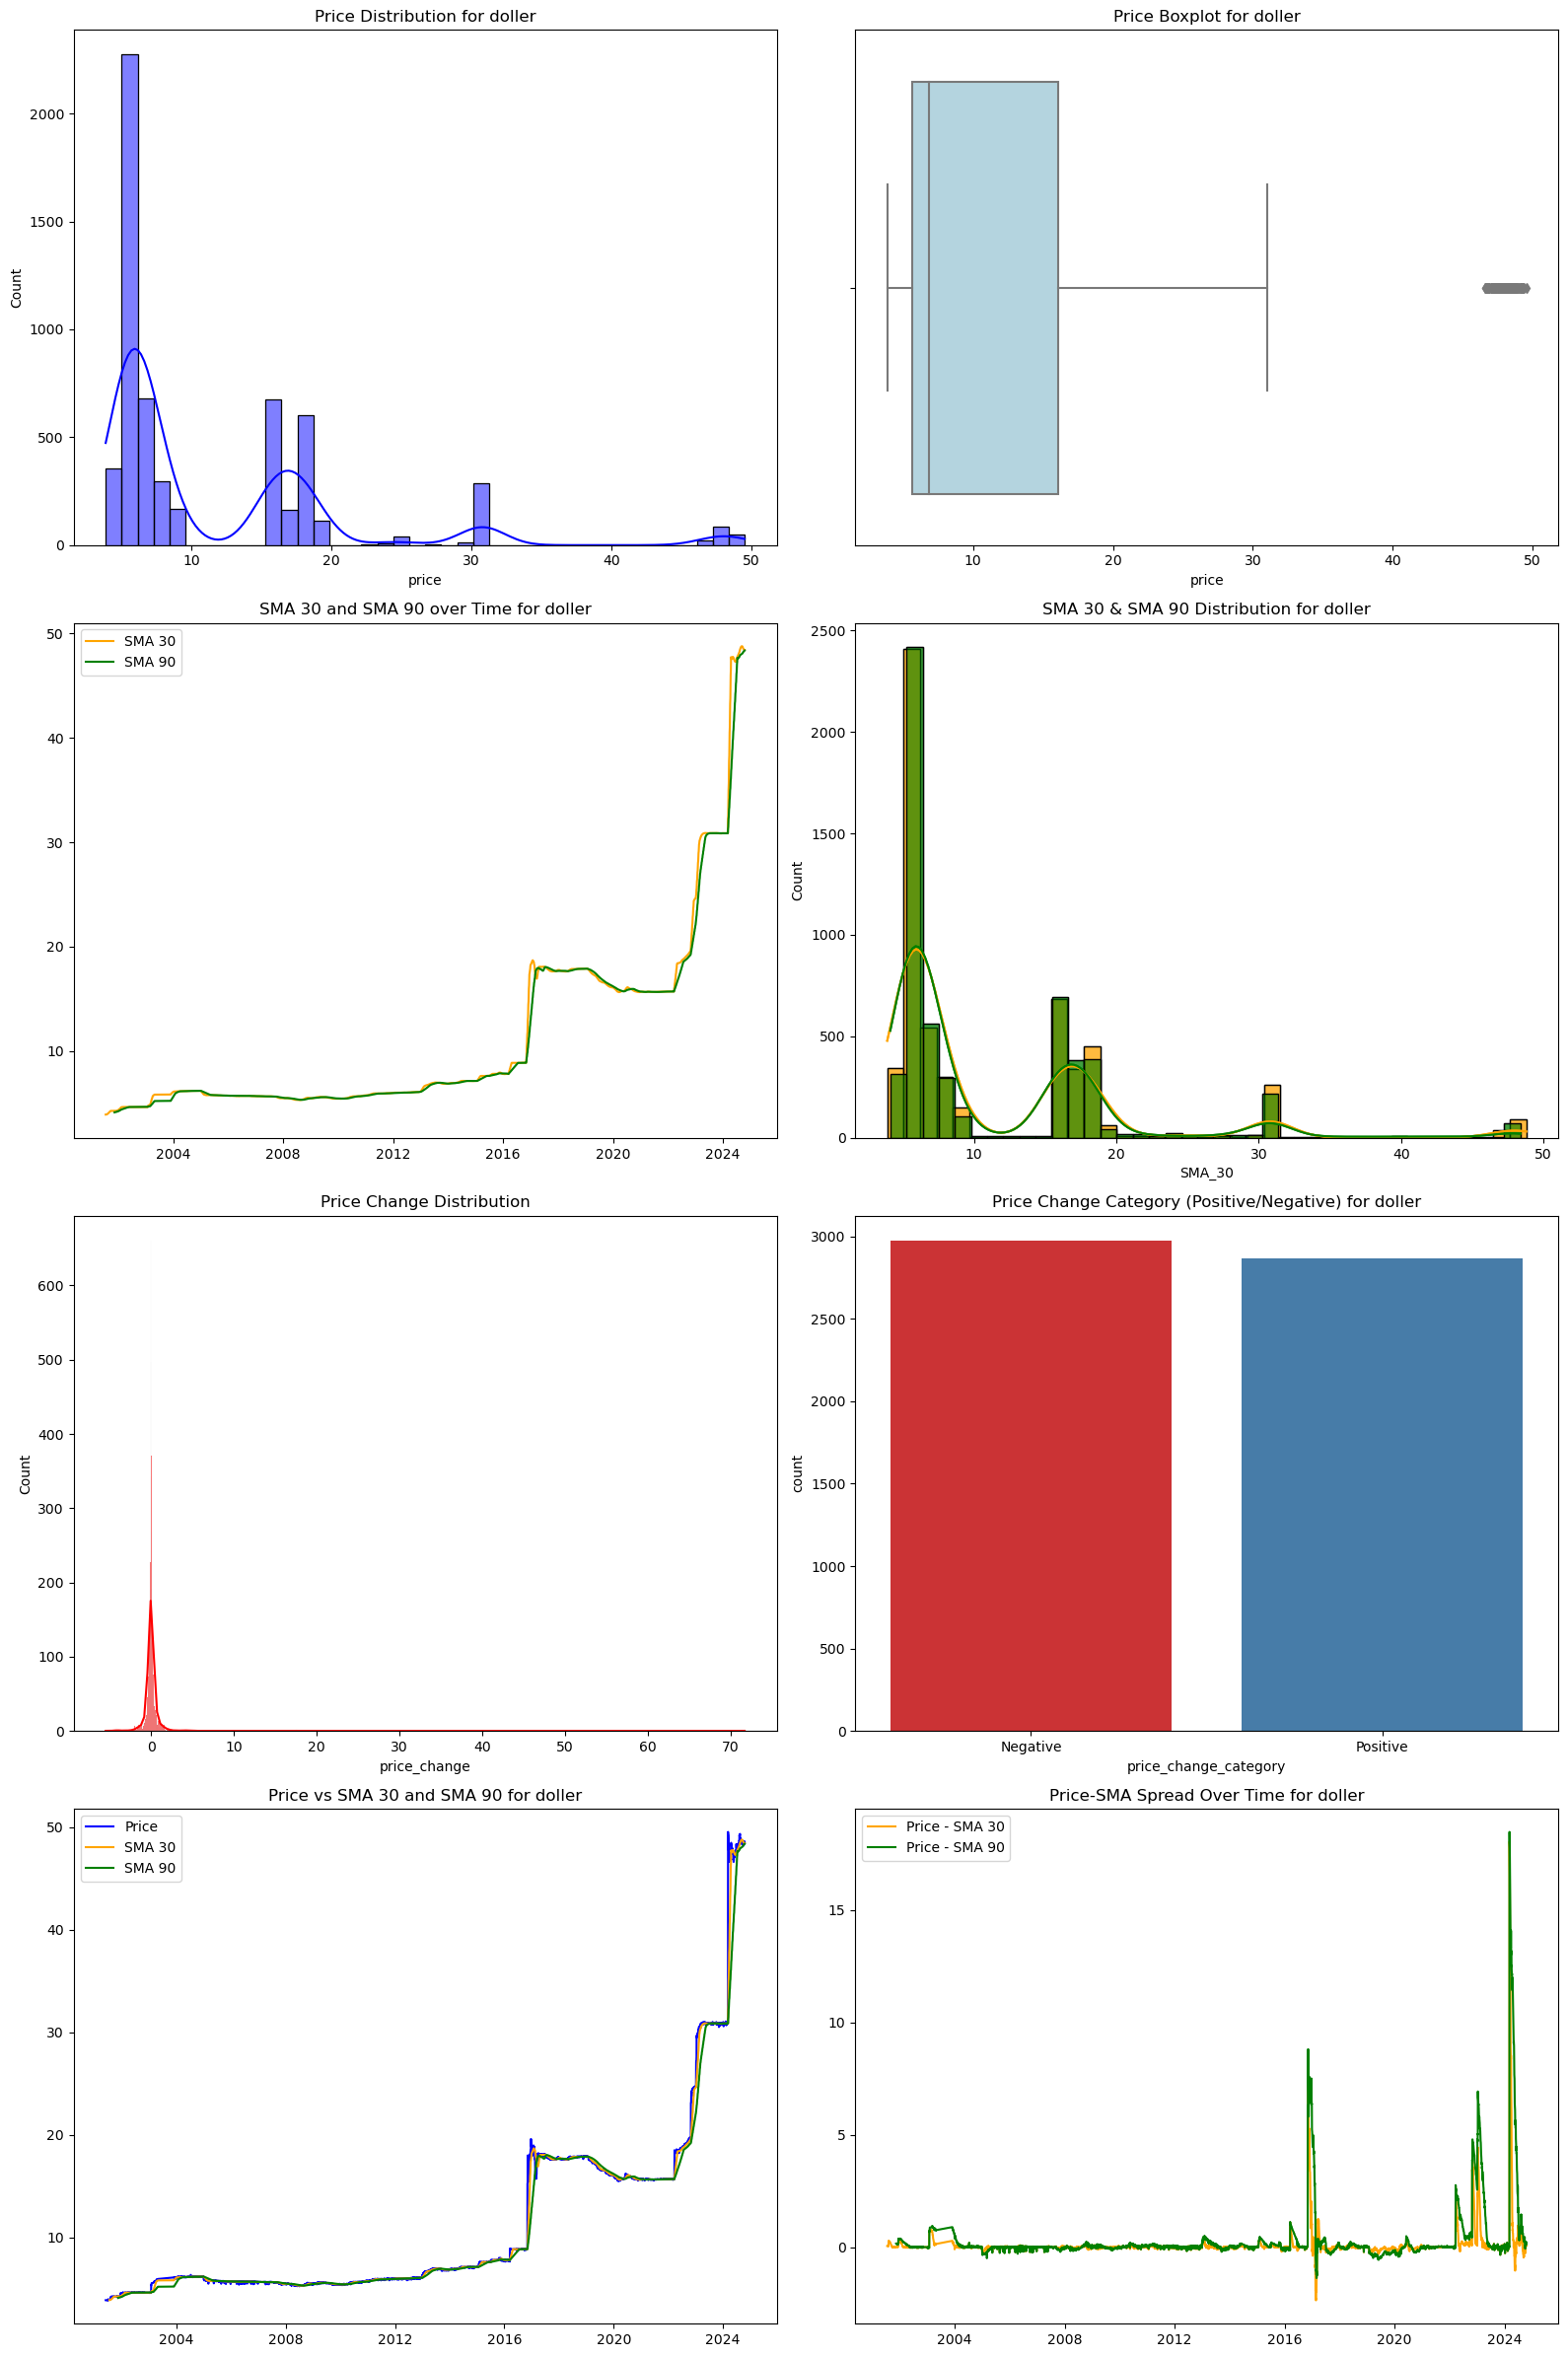

In [18]:
univariate_analysis(doller, "doller")

# Multivariate Analysis: Price vs SMA 30, SMA 90 (Line Plot & Spread Plot)

In [19]:
def multivariate_analysis(df: pd.DataFrame, category: str):
    plt.figure(figsize=(16, 10))

    plt.subplot(2, 2, 1)
    plt.plot(pd.to_datetime(df['date']), df['price_change'], color='red')
    plt.title(f'Price Change Over Time for {category}')

    
    plt.subplot(2, 2, 2)
    plt.plot(pd.to_datetime(df['date']), df['price'], color='blue')
    plt.title(f'Price Over Time for {category}')

    
    plt.subplot(2, 2, 3)
    corr = df[['price', 'SMA_30', 'SMA_90', 'price_change']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap for {category}')

    
    plt.subplot(2, 2, 4)
    sns.scatterplot(x='SMA_30', y='price_change', data=df, color='orange', label='SMA 30')
    sns.scatterplot(x='SMA_90', y='price_change', data=df, color='green', label='SMA 90')
    plt.title(f'Price Change vs. SMA 30 & SMA 90 for {category}')

    plt.tight_layout()
    plt.show()


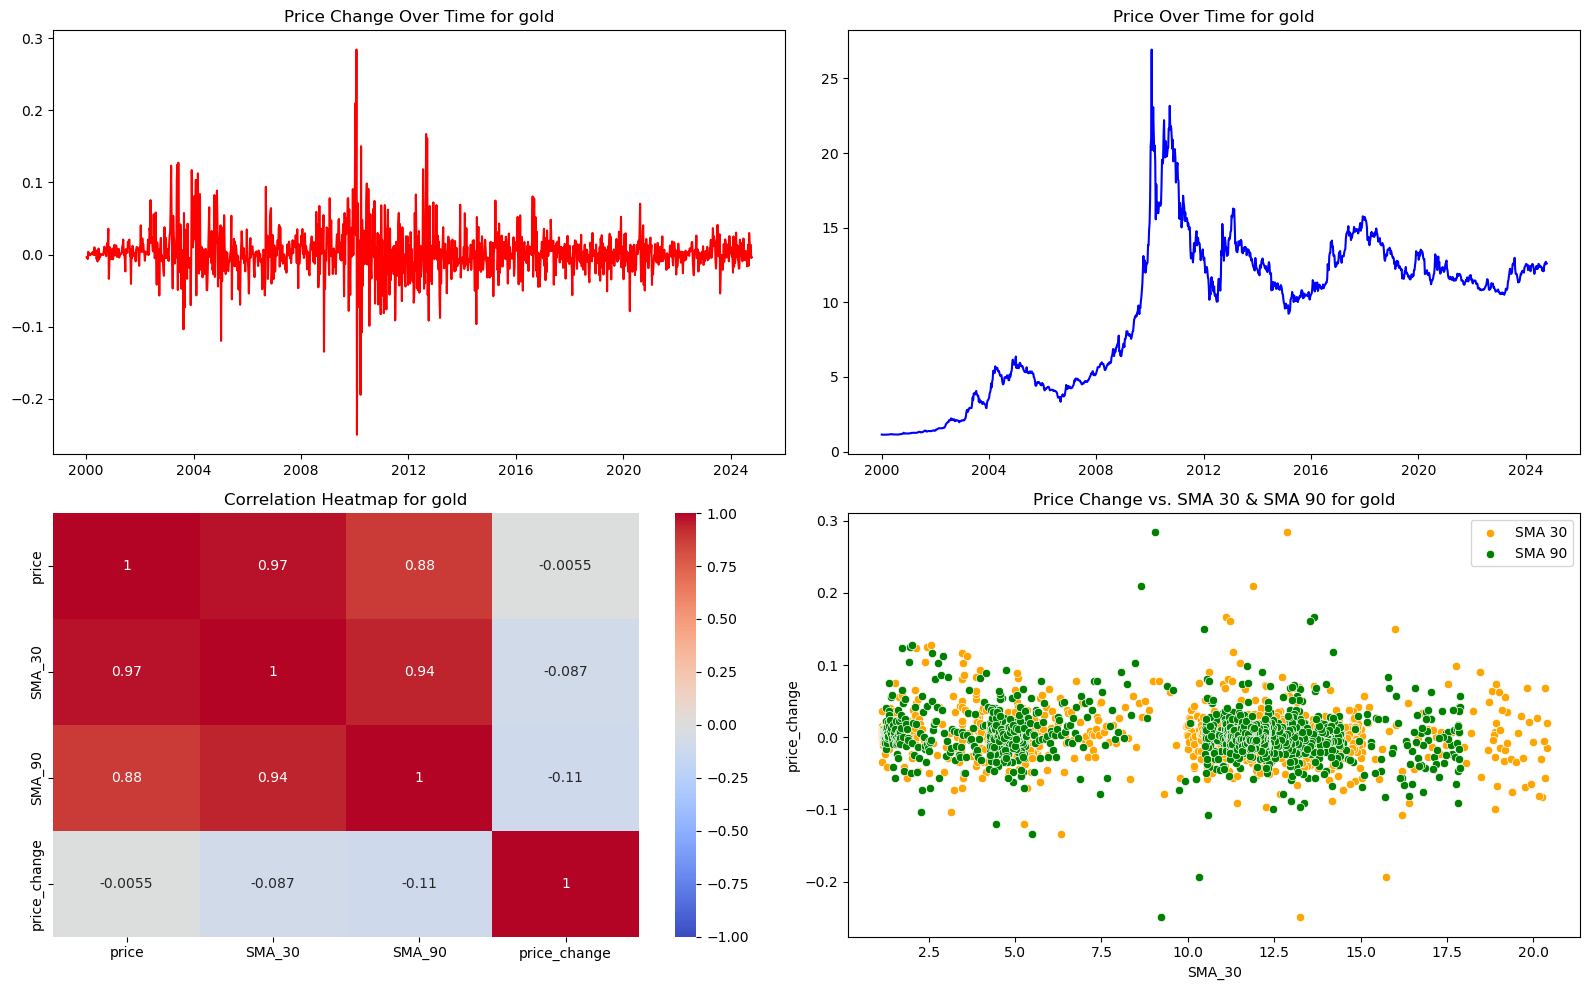

In [20]:
multivariate_analysis(gold, "gold")

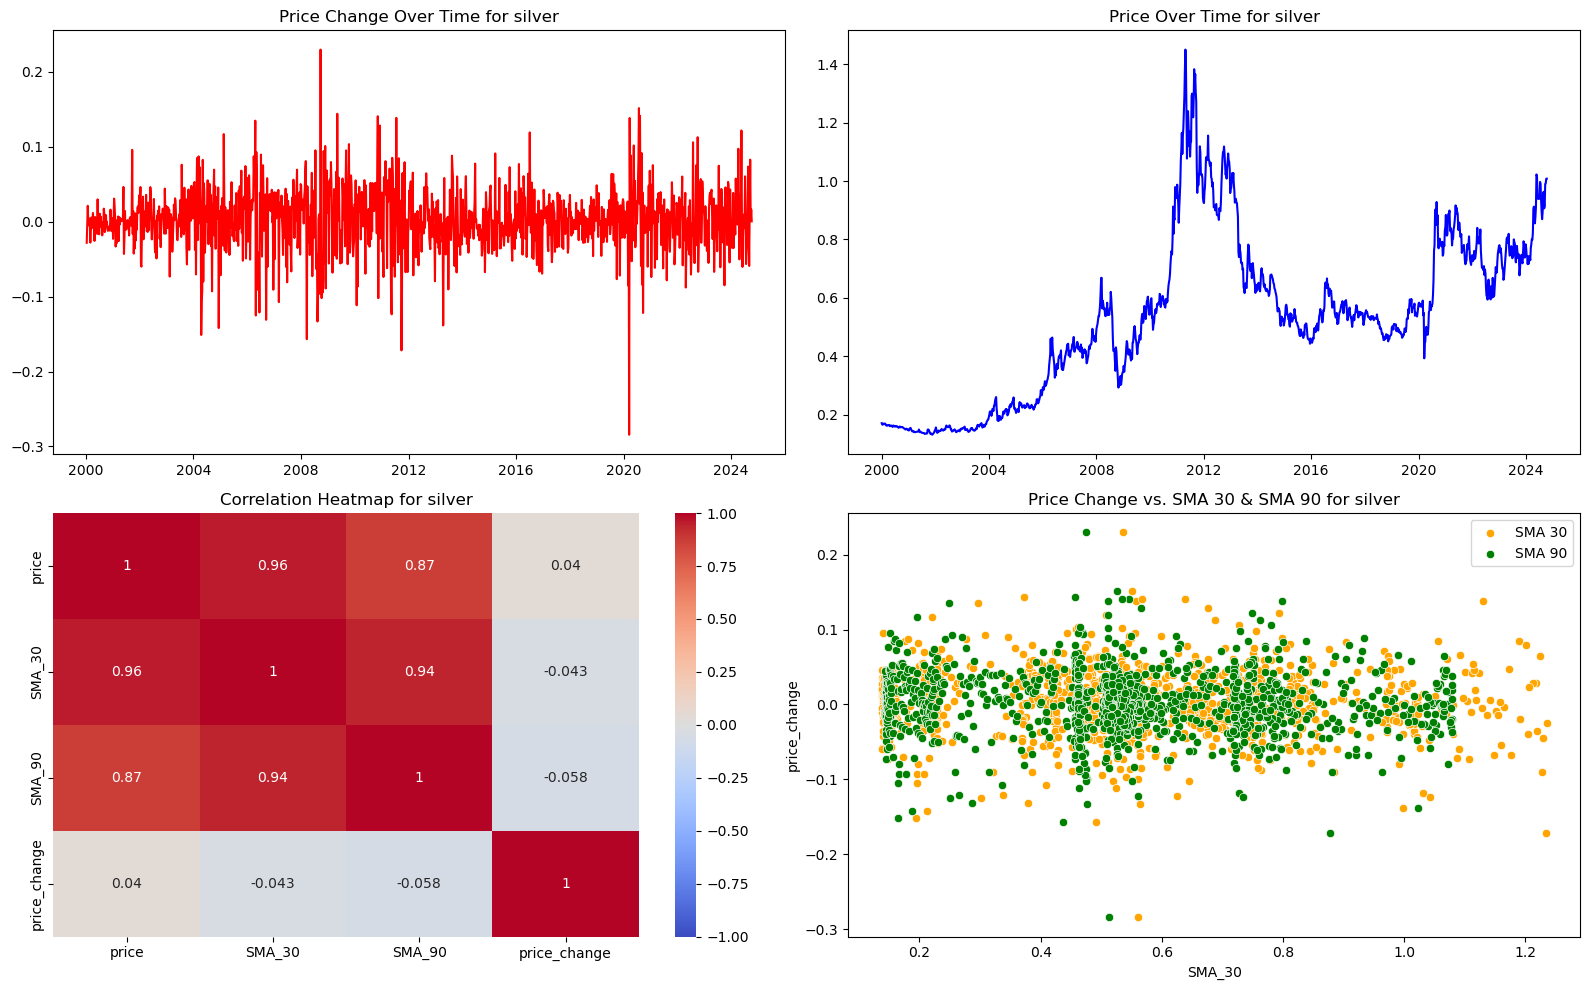

In [21]:
multivariate_analysis(silver, "silver")

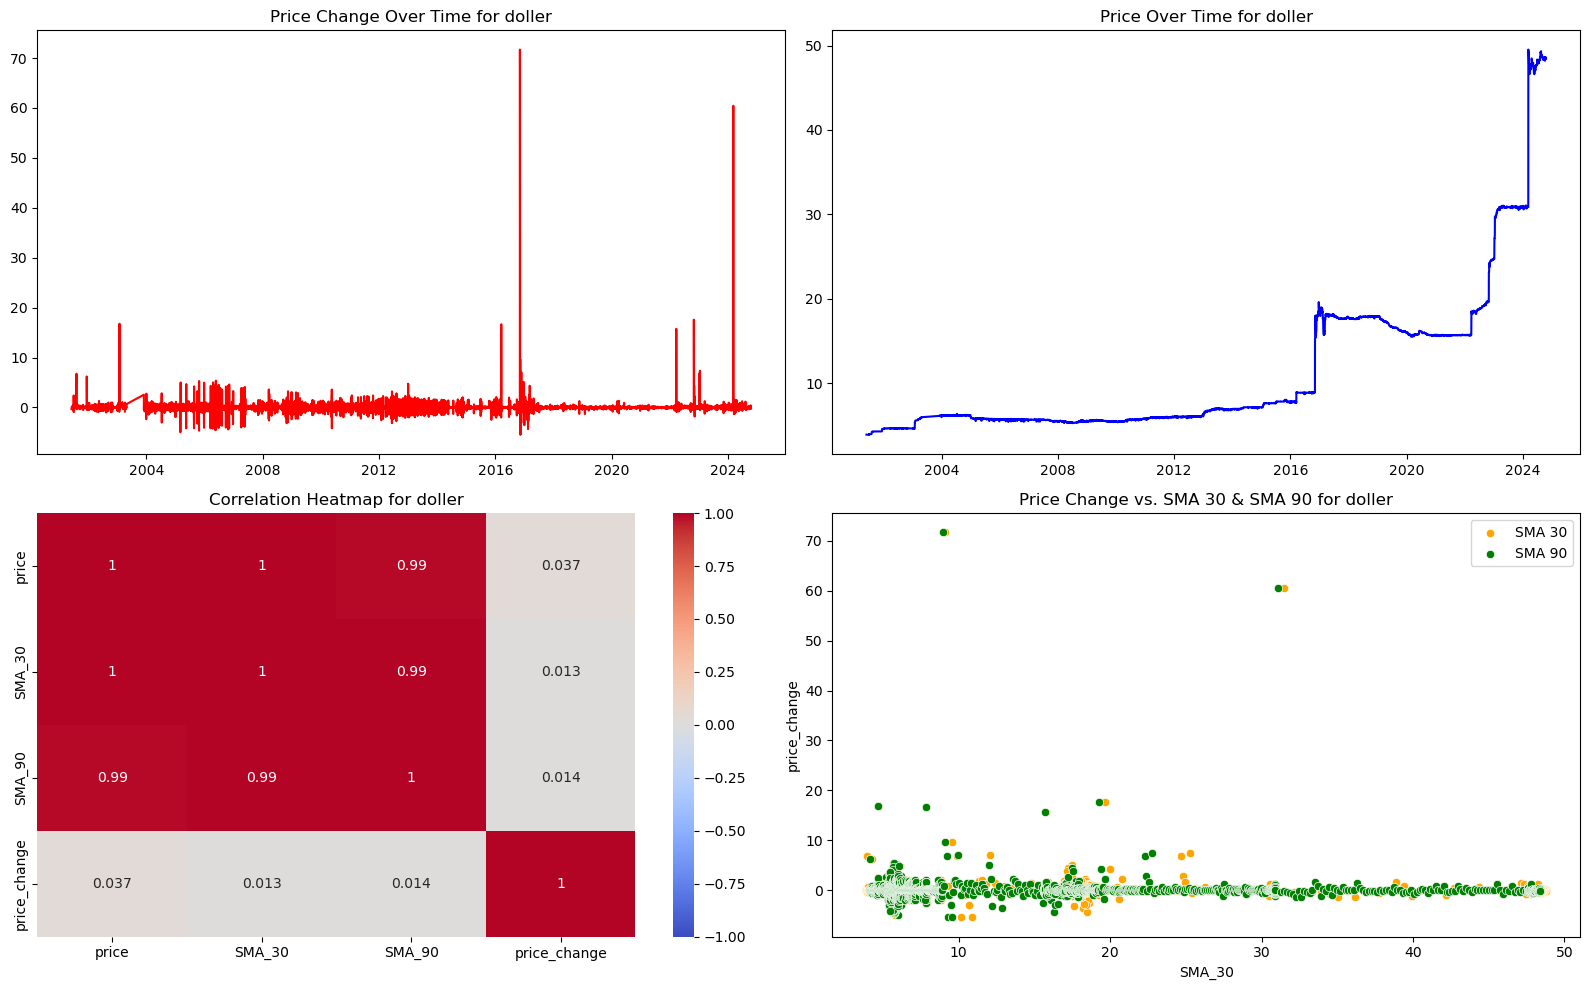

In [22]:
multivariate_analysis(doller, "doller")

# Pre-processing data

In [23]:
def fill_na(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop("price_change_category", axis=1)
    df = df.fillna(method="bfill")
    return df

In [24]:
def to_datetime(df: pd.DataFrame) -> pd.DataFrame:
    df["year"] = (pd.to_datetime(df.date).dt.year).astype(str)
    df["month"] = (pd.to_datetime(df.date).dt.month).astype(str)
    df["day"] = (pd.to_datetime(df.date).dt.day).astype(str)
    df['ds'] = pd.DatetimeIndex(df['year'] + "-" + df["month"] + "-" + df["day"])
    df = df.sort_values('date')
    return df

In [25]:
gold_data = to_datetime(fill_na(gold))
silver_data = to_datetime(fill_na(silver))
doller_data = to_datetime(fill_na(doller))

In [26]:
silver_data

,date,price,SMA_30,SMA_90,price_change,year,month,day,ds
0,2000-01-03 23:00:00,0.1705,0.163160,0.151688,-0.028152,2000,1,3,2000-01-03
1,2000-01-10 23:00:00,0.1657,0.163160,0.151688,-0.028152,2000,1,10,2000-01-10
2,2000-01-17 23:00:00,0.1649,0.163160,0.151688,-0.004828,2000,1,17,2000-01-17
3,2000-01-24 23:00:00,0.1684,0.163160,0.151688,0.021225,2000,1,24,2000-01-24
4,2000-01-31 23:00:00,0.1686,0.163160,0.151688,0.001188,2000,1,31,2000-01-31
...,...,...,...,...,...,...,...,...,...
1282,2024-09-10 12:00:00,0.9146,0.895400,0.797677,0.008713,2024,9,10,2024-09-10
1283,2024-09-17 12:00:00,0.9904,0.903693,0.800063,0.082878,2024,9,17,2024-09-17
1284,2024-09-24 12:00:00,0.9920,0.912463,0.802410,0.001616,2024,9,24,2024-09-24
1285,2024-10-01 12:00:00,1.0082,0.920373,0.805213,0.016331,2024,10,1,2024-10-01


In [27]:
def drop_columns(df: pd.DataFrame) -> None:
    columns = ['SMA_30', 'SMA_90', 'price_change', 'year', 'month', 'day', 'date']
    df.drop(columns=columns, inplace=True)

In [28]:
drop_columns(gold_data)
drop_columns(silver_data)
drop_columns(doller_data)

In [32]:
silver_data

,price,ds
0,0.1705,2000-01-03
1,0.1657,2000-01-10
2,0.1649,2000-01-17
3,0.1684,2000-01-24
4,0.1686,2000-01-31
...,...,...
1282,0.9146,2024-09-10
1283,0.9904,2024-09-17
1284,0.9920,2024-09-24
1285,1.0082,2024-10-01


# Modelling (Train & Eval)

In [30]:
from prophet import Prophet

In [43]:
def train_model(df: pd.DataFrame):
    df.rename(columns={"price": "y"}, inplace=True)
    m = Prophet(interval_width=0.95, daily_seasonality=True)
    
    model = m.fit(df)
    return model, m

In [78]:
model_doller, m_doller = train_model(doller_data)

00:19:19 - cmdstanpy - INFO - Chain [1] start processing
00:19:22 - cmdstanpy - INFO - Chain [1] done processing


In [81]:
model_gold, m_gold = train_model(gold_data)

00:19:31 - cmdstanpy - INFO - Chain [1] start processing
00:19:32 - cmdstanpy - INFO - Chain [1] done processing


In [82]:
model_silver, m_silver = train_model(silver_data)

00:19:38 - cmdstanpy - INFO - Chain [1] start processing
00:19:38 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
def make_forecast(m: Prophet) -> pd.DataFrame:
    future = m.make_future_dataframe(periods=100, freq="D")
    forecast = m.predict(future)
    
    m.plot(forecast)
    
    m.plot_components(forecast)
    return forecast

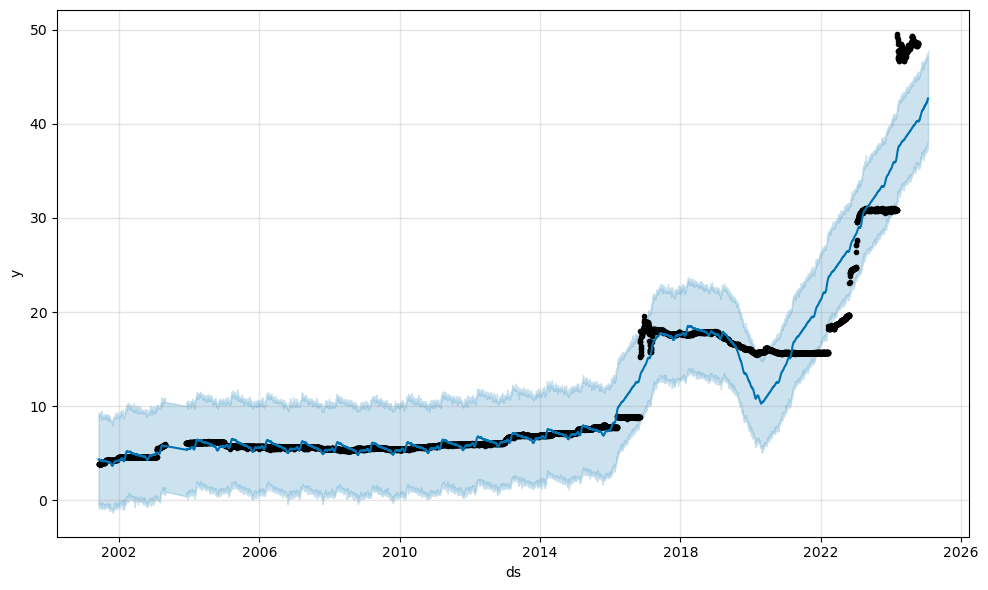

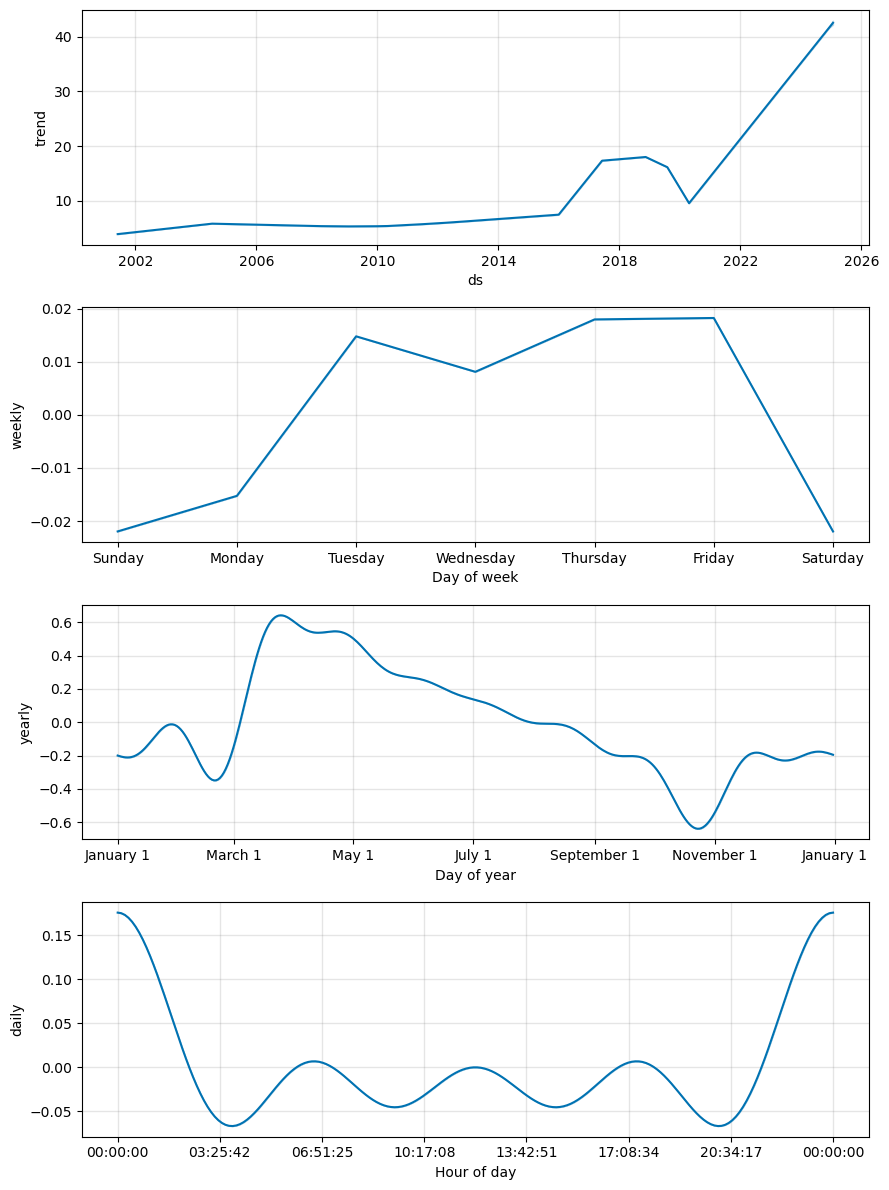

In [85]:
forecast = make_forecast(m_doller)

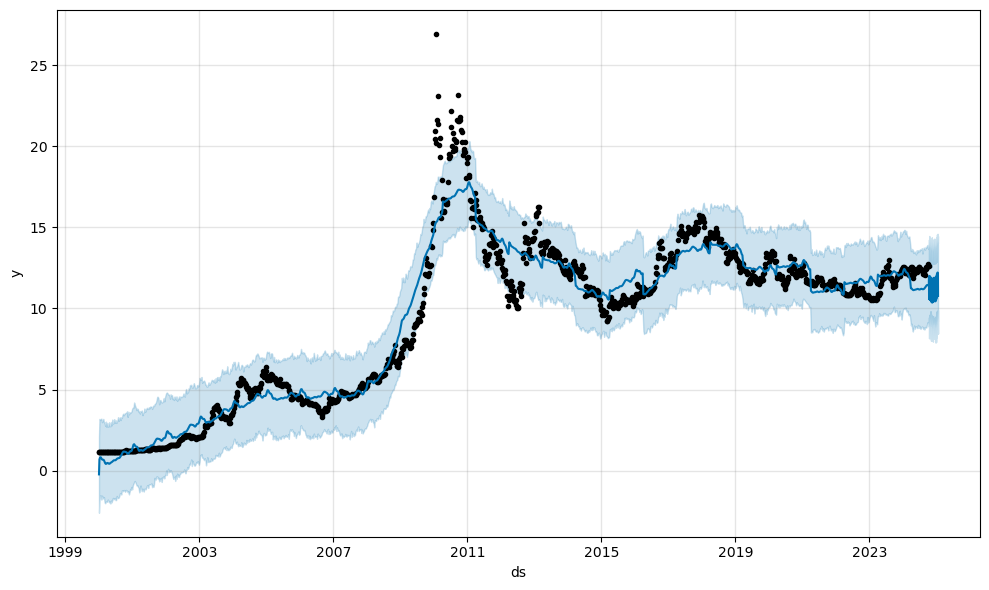

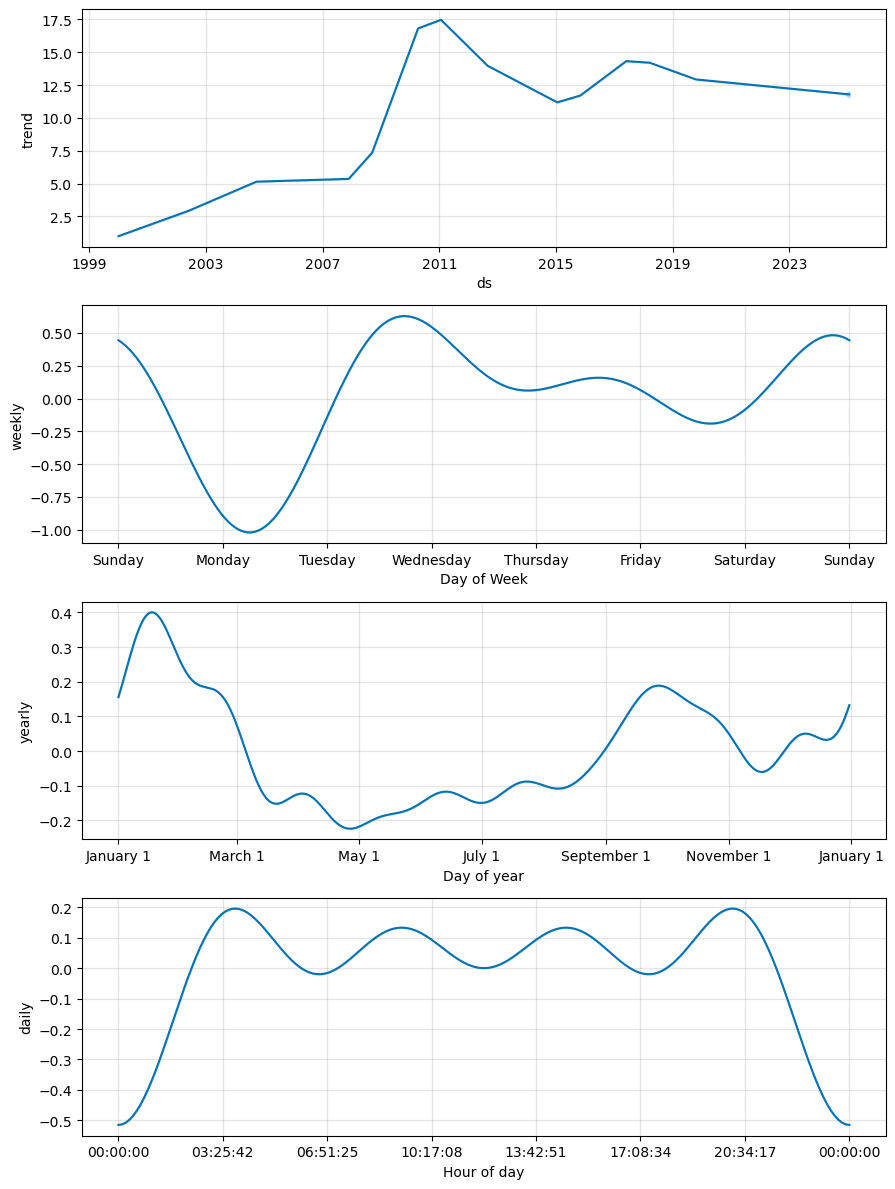

In [86]:
forecast = make_forecast(m_gold)

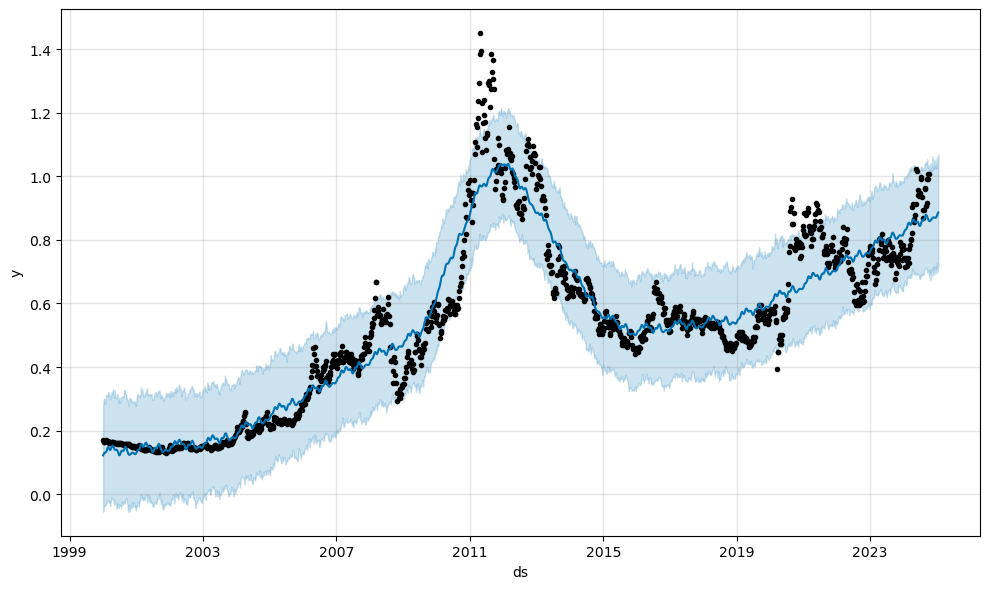

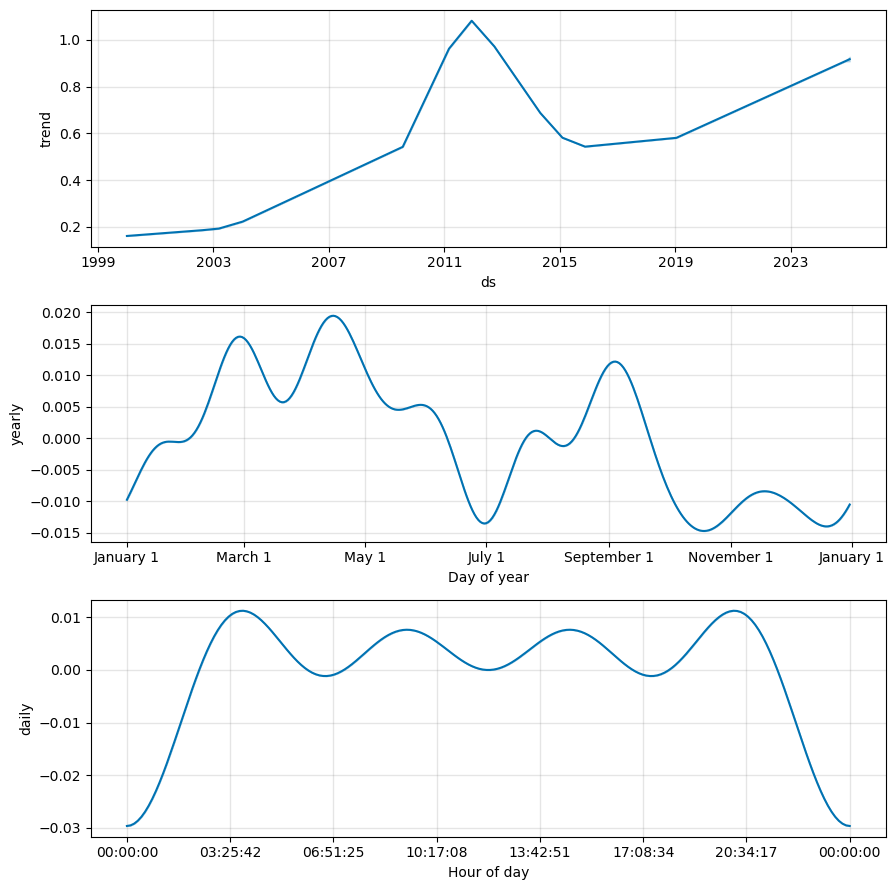

In [87]:
forecast = make_forecast(m_silver)